# TEI Benchmarking & Optimization

The goal of this notebook is to explore ways to optimze a TEI deployment. In particular we will:

1. Deploy an embedding model with TEI to Inference Endpoints via the Hub library
2. Run a set of experimental load tests against the endpoint using k6
3. Analyze the results to understand optimal params for `batch_size` and `concurrency`
4. Implement an efficient pipeline in Python to bulk embed chunks of text while handling errors gracefully

**NOTE -** To run this ntoebook, you'll need to have a `.env` file in this directory containing

- `HF_API_KEY` - a valid HF token
- `HOST` - the URL of your deployed endpoint (this will be available after step 1)


## 1. Deploy Embedding Model with TEI on Inference Endpoints


In [1]:
import os
from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

load_dotenv(override=True)
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HF_API_KEY")

In [2]:
from huggingface_hub import create_inference_endpoint

model_id = "BAAI/bge-base-en-v1.5"

endpoint = create_inference_endpoint(
    name="bge-base-en-v15-arr-tei-test",
    repository=model_id,
    framework="pytorch",
    task="sentence-embeddings",
    accelerator="gpu",
    vendor="aws",
    region="us-east-1",
    type="protected",
    namespace="HF-test-lab",
    instance_type="g5.2xlarge",
    instance_size="medium",
    custom_image={
        "health_route": "/health",
        "env": {
            "MAX_CONCURRENT_REQUESTS": "4096",
            "MAX_BATCH_TOKENS": "65536",
            "MAX_CLIENT_BATCH_SIZE": "2048",
            "MODEL_ID": "/repository",
        },
        "url": "ghcr.io/huggingface/text-embeddings-inference:86-0.6",  # A10 GPU specific!
    },
)

endpoint.wait()
print(endpoint.status)

In [3]:
# use this value to set in `.env` file as HOST
endpoint.url

## 2. Benchmark the Endpoint with k6

[k6 is an open source framework](https://k6.io/docs/) for load testing with a Javascript client. We'll use it here as it's well supported/documented and has great developer experience. You'll need to have k6 [installed locally](https://k6.io/docs/get-started/installation/).

Our goal is to run load tests while varying payload `batch_size` and `concurrency_level` and optimize those for throughput (embeddings per second) since this is what we care about for bulk (offline) embedding use cases.

Here we'll run a [Constant VU's Exector](https://k6.io/docs/using-k6/scenarios/executors/constant-vus/), which allows us to run a fixed number of virtual users (i.e. concurrency level) for a set duration of time.


### Run single load test


In [2]:
import subprocess


def run_k6_benchmark(vu: int, bs: int, duration: str, n_tokens: int, file_path: str):
    """
    Run a k6 benchmark with the given parameters.

    If file_path is provided, the resutls will be saved to the file.

    Args:
        vu (int): The number of virtual users.
        bs (int): The batch size.
        duration (str): The duration of the benchmark in seconds (eg. "10s").
        n_tokens (int): The number of tokens.
        file_path (str): The file path.
    """
    command = f'k6 run tei-benchmark.js -e VU={vu} -e BATCH_SIZE={bs} -e DURATION={duration} -e N_TOKENS={n_tokens} -e FILE_PATH={file_path} -e HOST={os.getenv("HOST")} -e HF_API_KEY={os.getenv("HF_API_KEY")}'

    try:
        subprocess.run(command, shell=True, check=True, text=True, timeout=45)
    except subprocess.TimeoutExpired as e:
        print("Timeout occurred:", e)
        raise e

In [ ]:
FILE_PATH = "k6-summary.json"
N_TOKENS = 512
DURATION = "20s"
BATCH_SIZE = 8
CONCURRENCY = 100

run_k6_benchmark(CONCURRENCY, BATCH_SIZE, DURATION, N_TOKENS, FILE_PATH)

### Run grid search of load test experiments


In [3]:
import os
import json
from typing import List


def run_k6_experiment(
    vus: List[int], bs: List[int], duration: int, save_dir: str
) -> None:
    """
    Run k6 experiment with different configurations of virtual users (VUs) and batch sizes (bs).

    Args:
        vus (List[int]): List of virtual users to run the benchmark with.
        bs (List[int]): List of batch sizes to run the benchmark with.
        duration (int): Duration of the benchmark in seconds.
        save_dir (str): Directory to save the benchmark results.

    Returns:
        None
    """
    N_TOKENS = 512
    os.makedirs(save_dir, exist_ok=True)

    for vu in vus:
        for batch_size in bs:
            print("Running Benchmark with VU:", vu, "and Batch Size:", batch_size)
            FILE_PATH = f"k6-benchmark-result-vu-{vu}-bs-{batch_size}.json"

            try:
                run_k6_benchmark(
                    vu,
                    batch_size,
                    duration,
                    N_TOKENS,
                    os.path.join(save_dir, FILE_PATH),
                )
            except Exception as e:
                print("File Path:", FILE_PATH)
                print("Error:", e, "\n")

                # save empty file
                with open(os.path.join(save_dir, FILE_PATH), "w") as f:
                    f.write(json.dumps({"error": True}))
                continue

In [ ]:
save_dir = "./k6-experiment-results"
batch_sizes = [1, 4, 8, 16, 32, 64, 128, 256, 512]
concurrency_levels = [1, 50, 100, 250, 500, 1000]

run_k6_experiment(
    vus=concurrency_levels,
    bs=batch_sizes,
    duration="30s",
    save_dir=save_dir,
)

## 3. Analyze Results


In [7]:
from utils import load_k6_results, plot_heatmap, save_results

experiment_results = load_k6_results(save_dir)

result_file = os.path.join(save_dir, "curated.jsonl")
if not os.path.exists(result_file):
    save_results(experiment_results, result_file)

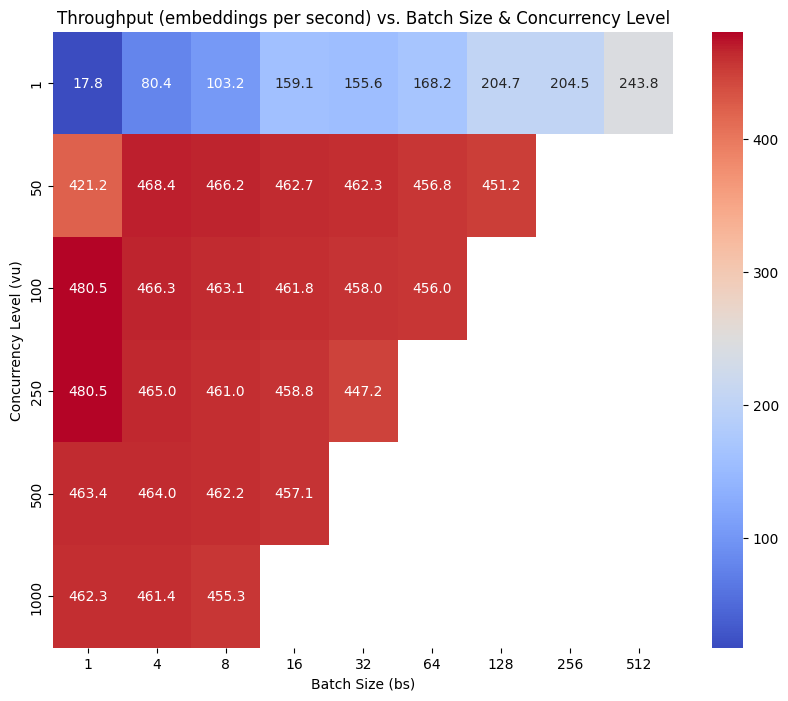

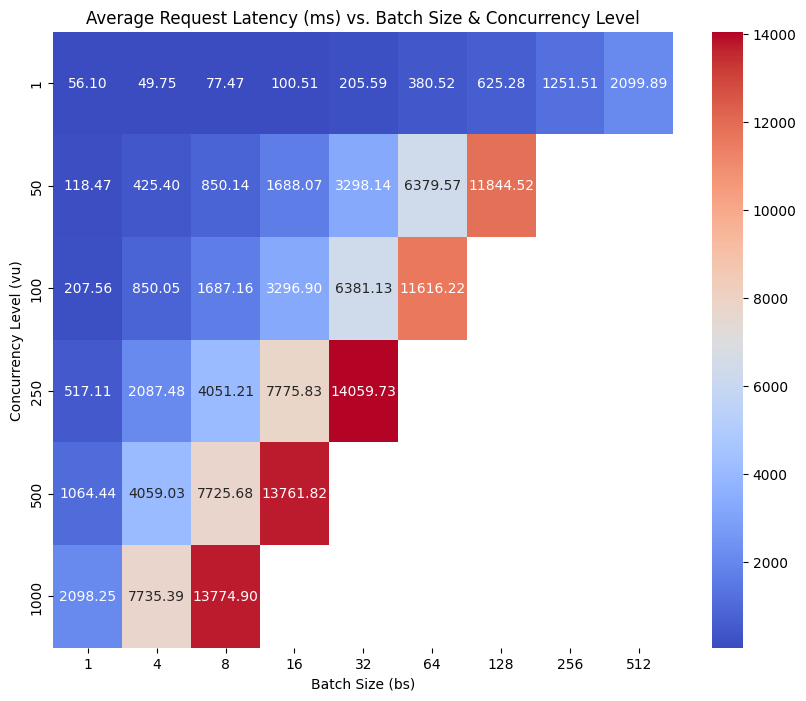

In [8]:
plot_heatmap(os.path.join(save_dir, "curated.jsonl"))

Looks like `batch_size==1` and `concurrency_level` between 100 and 250 is best... lets further explore this space.


### Futher explore hyperparam space


In [9]:
save_dir = "./k6-experiment-results-2"
batch_sizes = [1, 4]
concurrency_levels = [100, 150, 200, 250, 300, 350]

run_k6_experiment(
    vus=concurrency_levels,
    bs=batch_sizes,
    duration="30s",
    save_dir=save_dir,
)

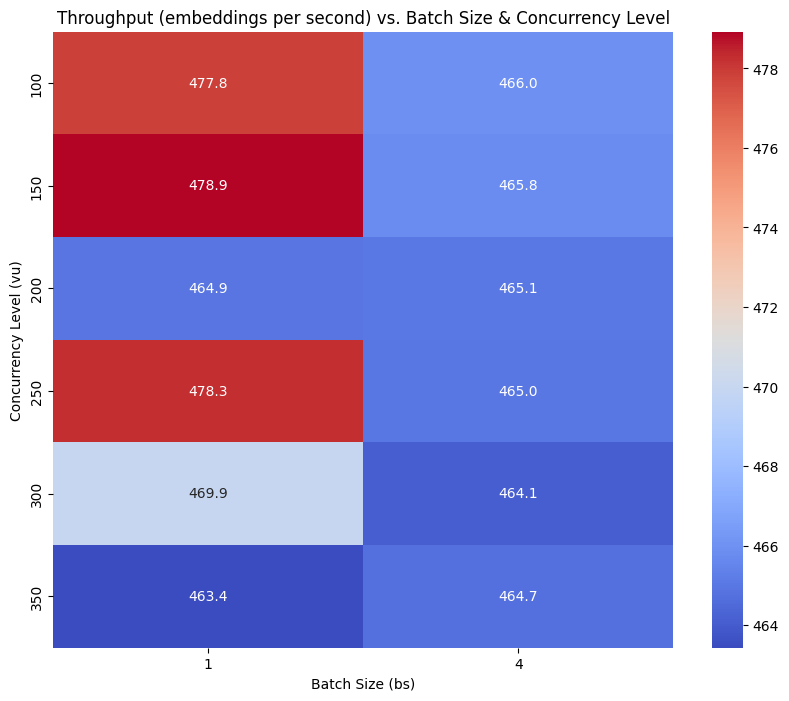

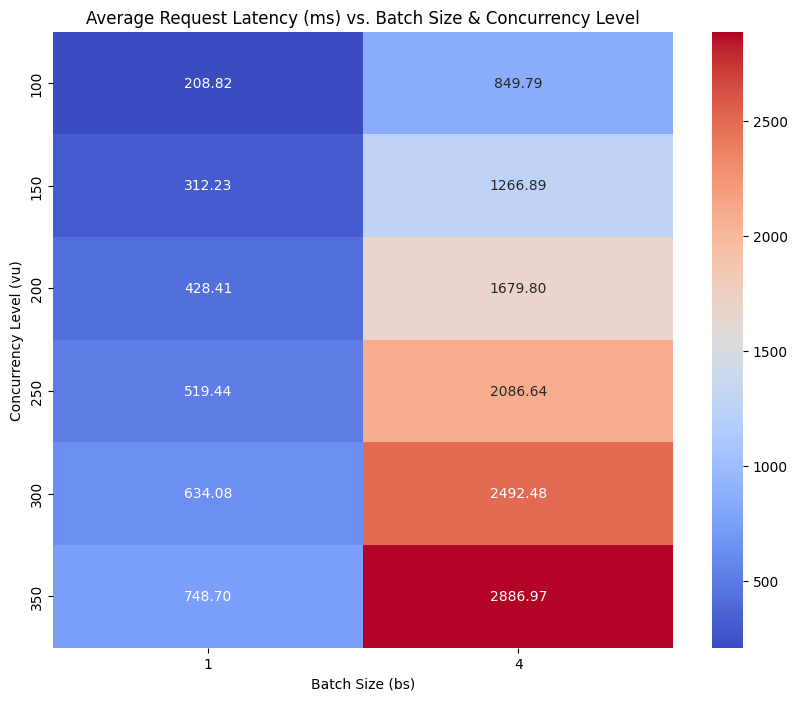

In [10]:
experiment_results = load_k6_results(save_dir)

result_file = os.path.join(save_dir, "curated.jsonl")
if not os.path.exists(result_file):
    save_results(experiment_results, result_file)


plot_heatmap(os.path.join(save_dir, "curated.jsonl"))

Cool, looks like `concurrency_level` of 150 gives the highest RPS.


## 4. Efficient Inference Pipeline in Python

Let's use these optimal settings to run an inference pipeline for bulk embedding data efficeintly in Python.

Our inference pipeline impelments a framework for asynchronously fetching embeddings for a large dataset of texts using an external API, processing these texts in batches, and then calculating various performance metrics to assess the efficiency of the operation.

The key pieces include:

1. Batch Generator Function (`batch_generator`): This utility function divides the input dataset into smaller, manageable batches. Each batch contains a specified number of text entries, facilitating parallel processing and reducing memory overhead during the operation.

2. Asynchronous Embedding Fetch Function (`fetch_embeddings`): It asynchronously sends a batch of texts to an external API to obtain their embeddings. This function uses aiohttp for non-blocking HTTP requests and an `asyncio.Semaphore` to limit the number of concurrent requests, thus preventing overloading the API server. It handles successful responses by extracting embeddings and timing information, and errors by recording them appropriately.

3. Calculate Statistics Function (`calculate_statistics`): This function computes various statistical measures (minimum, maximum, mean, median, 90th percentile, and 95th percentile) for performance metrics collected during the embedding fetching process. These metrics help in understanding the performance characteristics of the operation, such as how long it takes to tokenize texts, queue times, and inference times.

4. Main Coroutine (`run_bulk_embed)`: Orchestrates the entire pipeline by generating batches of data, initiating asynchronous tasks to fetch embeddings for these batches, collecting and logging timing metrics, and finally computing and returning overall performance statistics. It leverages Python's `asyncio` framework for concurrency, enabling efficient utilization of network and CPU resources.


In [11]:
import os
from transformers import AutoTokenizer
from tei_benchmark import run_bulk_embed

In [13]:
# generate some dummy records to embed
tokenizer = AutoTokenizer.from_pretrained(model_id)
data = [
    {"unique_id": n, "text": "hello " * tokenizer.model_max_length}
    for n in range(10_000)
]

In [15]:
if os.path.exists("embeddings.jsonl"):
    os.remove("embeddings.jsonl")

results = await run_bulk_embed(
    data, batch_size=1, concurrency=100, filename="embeddings.jsonl"
)

Batch Size: 1, Concurrency Level: 100, Total Time: 21.1953 seconds, Embed per sec: 471.8027, Num Success: 10000, Num Failures: 0


In [17]:
if os.path.exists("embeddings.jsonl"):
    os.remove("embeddings.jsonl")

results = await run_bulk_embed(
    data, batch_size=1, concurrency=150, filename="embeddings.jsonl"
)

Batch Size: 1, Concurrency Level: 150, Total Time: 21.2483 seconds, Embed per sec: 470.6259, Num Success: 10000, Num Failures: 0


## Resources

- On asyncio in Python: https://superfastpython.com/asyncio-gather/
- On `as_completed()` vs. `gather()`: https://jxnl.github.io/instructor/blog/2023/11/13/learn-async/#asyncioas_completed-handling-tasks-as-they-complete
